In [6]:
import keras
import numpy as np
import tensorflow as tf
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import sklearn
import tempfile
import sys
from sklearn.metrics import classification_report, confusion_matrix

print("环境准备完毕")

环境转变完毕


## 加载数据集 

In [7]:
def load_data_fashion_mnist(mnist_train, mnist_test, batch_size):
    if sys.platform.startswith('win'):
        num_workers = 0
    else:
        num_workers = 4
    train_iter = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_iter, test_iter

# 使用临时目录
with tempfile.TemporaryDirectory() as tmpdirname:
    train_loader = DataLoader(
        datasets.FashionMNIST(
            root=tmpdirname, 
            train=True, 
            transform=transforms.ToTensor(), 
            download=True
        ), 
        batch_size=64, 
        shuffle=True
    )
    test_loader = DataLoader(
        datasets.FashionMNIST(
            root=tmpdirname, 
            train=False, 
            transform=transforms.ToTensor(), 
            download=True
        ), 
        batch_size=64, 
        shuffle=False
    )

    mnist_train = torchvision.datasets.FashionMNIST(
        root=tmpdirname, 
        train=True, 
        download=True, 
        transform=transforms.ToTensor()
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root=tmpdirname, 
        train=False, 
        download=True, 
        transform=transforms.ToTensor()
    )

    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


batch_size = 64
train_iter, test_iter = load_data_fashion_mnist(mnist_train, mnist_test, batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_dir = 'results/process_picture/'
weight_dir = 'results/weight/'

#训练参数
lr, num_epochs = 0.001, 3

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /tmp/tmpn4nu78o0/FashionMNIST/raw/train-images-idx3-ubyte.gz to /tmp/tmpn4nu78o0/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /tmp/tmpn4nu78o0/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /tmp/tmpn4nu78o0/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /tmp/tmpn4nu78o0/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/tmpn4nu78o0/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /tmp/tmpn4nu78o0/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/tmpn4nu78o0/FashionMNIST/raw



## 实际例子测试函数 

In [8]:
def test_example(net,test_loader):
    net.eval()
    test_images, test_labels = next(iter(test_loader))
    test_images, test_labels = test_images.to(device), test_labels.to(device)  # 将数据移动到 GPU 上
    with torch.no_grad():
        output = net(test_images[:5])

    # 将输出转换为类别索引
    predicted_labels = torch.argmax(output, dim=1)
    actual_labels = test_labels[:5]

    # 打印转换后的预测结果和实际标签
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    print("Predicted labels:\n", [class_names[label] for label in predicted_labels.cpu().numpy()])
    print("Actual labels:\n", [class_names[label] for label in actual_labels.cpu().numpy()])

    # 可视化第一个图像和预测结果
    image = test_images[1].cpu().numpy().transpose((1, 2, 0))
    plt.imshow(image.squeeze(), cmap='gray')  # 将图像数据移动回 CPU
    plt.title(f'Predicted: {class_names[predicted_labels[1].item()]}, Actual: {class_names[actual_labels[1].item()]}')
    plt.show()

## 总体预测效果函数 

In [9]:
def test_all(net,test_loader):
    net.to(device)
    net.eval()  # 设置为评估模式
    # 进行预测并收集测试结果
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = net(X)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # 计算评估指标
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=mnist_test.classes))

### 验证全连接神经网络 

#### 定义网络结构 

In [10]:
# 定义网络结构
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### 网络实例化 

In [12]:
fc_net = Network()
fc_net = torch.load('results/weight/FC_mnist.pth')

#### 实际例子预测 

Predicted labels:
 ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt']
Actual labels:
 ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt']


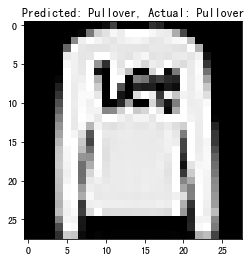

In [13]:
test_example(fc_net,test_loader)

#### 总体预测效果 

In [14]:
test_all(fc_net,test_loader)

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.76      0.90      0.83      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.82      0.77      0.80      1000
       Dress       0.92      0.84      0.88      1000
        Coat       0.75      0.88      0.81      1000
      Sandal       0.97      0.96      0.96      1000
       Shirt       0.77      0.61      0.68      1000
     Sneaker       0.94      0.96      0.95      1000
         Bag       0.97      0.96      0.97      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### 验证LeNet卷积网络 

#### 定义网络结构 

In [15]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

#### 网络实例化

In [16]:
Lenet = LeNet()
Lenet = torch.load('results/weight/LeNET_mnist.pth')

#### 实际例子预测 

Predicted labels:
 ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt']
Actual labels:
 ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt']


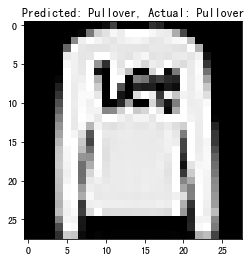

In [17]:
test_example(Lenet,test_loader)

#### 总体预测效果 

In [18]:
test_all(Lenet,test_loader)

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.76      0.90      0.83      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.82      0.77      0.80      1000
       Dress       0.92      0.84      0.88      1000
        Coat       0.75      0.88      0.81      1000
      Sandal       0.97      0.96      0.96      1000
       Shirt       0.77      0.61      0.68      1000
     Sneaker       0.94      0.96      0.95      1000
         Bag       0.97      0.96      0.97      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



###  验证AlexNET

#### 定义网络结构 

In [20]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),  # 1 通道改为 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        output = self.classifier(x)
        return output

#### 网络实例化 

In [21]:
Alexnet = AlexNet()
Alexnet = torch.load('results/weight/Alexnet_mnist.pth')

#### 实际例子测试 

Predicted labels:
 ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt']
Actual labels:
 ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt']


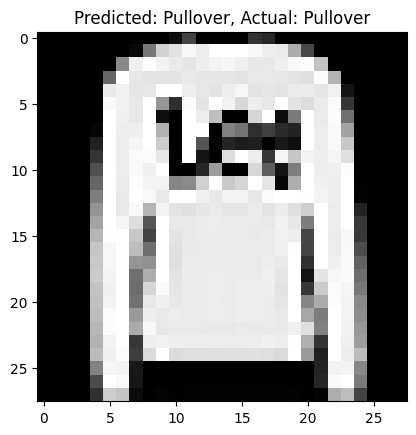

In [22]:
test_example(Alexnet,test_loader)

#### 总体测试效果 

In [23]:
test_all(Alexnet,test_loader)

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.86      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.89      0.87      0.88      1000
       Dress       0.92      0.94      0.93      1000
        Coat       0.86      0.90      0.88      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.77      0.76      0.77      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



### 验证vggNet卷积神经网络 

#### 网络搭建 

In [24]:
# 定义简化的 VGG 网络
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#### 网络实例化 

In [25]:
vggnet = VGGNet()
vggnet = torch.load('results/weight/vggnet_mnist.pth')

#### 实际例子测试 

Predicted labels:
 ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt']
Actual labels:
 ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt']


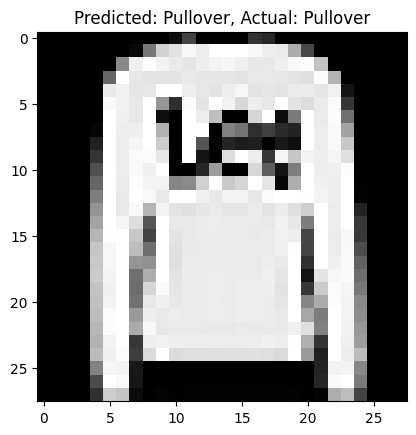

In [26]:
test_example(vggnet,test_loader)

#### 总体测试效果 

In [27]:
test_all(vggnet,test_loader)

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.91      0.81      0.86      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.82      0.90      0.86      1000
       Dress       0.91      0.92      0.92      1000
        Coat       0.88      0.84      0.86      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.74      0.77      0.75      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



### 验证resnet 

#### 网络搭建 

In [28]:
# 定义基本的残差块
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion * 4 * 4, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out
    
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

#### 网络实例化 

In [29]:
resnet = ResNet18()
resnet = torch.load('results/weight/resnet_mnist.pth')

#### 实际例子测试 

Predicted labels:
 ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt']
Actual labels:
 ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt']


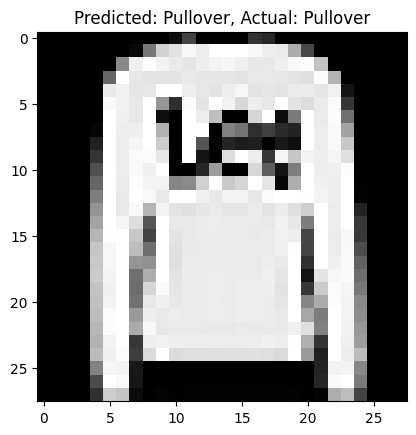

In [30]:
test_example(resnet,test_loader)

#### 全部样例测试 

In [31]:
test_all(resnet,test_loader)

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.86      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.90      0.91      0.91      1000
       Dress       0.94      0.91      0.92      1000
        Coat       0.87      0.92      0.89      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.78      0.78      0.78      1000
     Sneaker       0.97      0.97      0.97      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



###  验证DenseNet

#### 搭建网络 

In [32]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(torch.relu(self.bn1(x)))
        out = self.conv2(torch.relu(self.bn2(out)))
        out = torch.cat([out, x], 1)
        return out

class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(torch.relu(self.bn(x)))
        out = nn.functional.avg_pool2d(out, 2)
        return out

class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2 * growth_rate
        self.conv1 = nn.Conv2d(1, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0] * growth_rate
        self.trans1 = Transition(num_planes, num_planes // 2)
        num_planes = num_planes // 2

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1] * growth_rate
        self.trans2 = Transition(num_planes, num_planes // 2)
        num_planes = num_planes // 2

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2] * growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(1536, num_classes)
  # 修改全连接层输入维度

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for _ in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        # print("Input shape:", x.shape)
        out = self.conv1(x)
        # print("After Conv1:", out.shape)
        out = self.trans1(self.dense1(out))
        # print("After Dense1 and Trans1:", out.shape)
        out = self.trans2(self.dense2(out))
        # print("After Dense2 and Trans2:", out.shape)
        out = self.dense3(out)
        # print("After Dense3:", out.shape)
        out = torch.relu(self.bn(out))
        out = nn.functional.avg_pool2d(out, 3)
        # print("After final avg pool:", out.shape)
        out = out.view(out.size(0), -1)
        # print("Before Linear:", out.shape)
        out = self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck, [6, 12, 24], growth_rate=12)

densenet = DenseNet121().to(device)

#### 网络实例化 

In [33]:
densenet = DenseNet121()
densenet = torch.load("results/weight/densenet_mnist.pth")

#### 样例测试 

Predicted labels:
 ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt']
Actual labels:
 ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt']


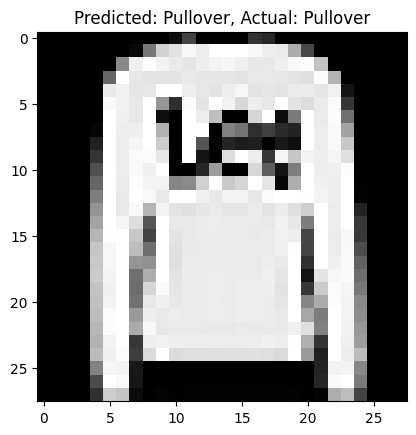

In [34]:
test_example(densenet,test_loader)

#### 全部测试 

In [35]:
test_all(resnet,test_loader)

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.86      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.90      0.91      0.91      1000
       Dress       0.94      0.91      0.92      1000
        Coat       0.87      0.92      0.89      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.78      0.78      0.78      1000
     Sneaker       0.97      0.97      0.97      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

